In [63]:
import math
class Value:
    data = None

    def __init__(self, data, children=(), op='', label = '') -> None:
        self.data = data
        self._children = set(children)
        self._op = op
        self.grad = 0
        self.label = label
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f'Value(data={self.data})'

    def __add__(self, other: 'Value') -> 'Value':
        other = other if isinstance(other, Value) else Value(data=other)
        output = self.data + other.data
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out = Value(data=output, children=(self, other), op='+')
        out._backward = _backward
        return out
    
    def __mul__(self, other: 'Value'):
        other = other if isinstance(other, Value) else Value(data=other)
        out = Value(data=self.data * other.data,
                    children=(self, other), op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(data=(self.data ** other), children=(self,), op=f'**{other}')
        def _backward():
            self.grad += (other *(self.data ** (other - 1))) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), f'e')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other: 'Value') -> 'Value':
        return self + other
    
    def __rmul__(self, other: 'Value') -> 'Value':
        return self * other

    def __neg__(self) -> 'Value':
        return self * -1

    def __sub__(self, other: 'Value'):
        return self + -other

    def __rsub__(self, other):
        return -self + other

    def __truediv__(self, other):
        return self * (other**-1)

    def __rtruediv__(self, other):
        return other * (self**-1)

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for n in reversed(topo):
            n._backward()
        


In [9]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph


In [64]:

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    # , node_attr={'rankdir': 'TB'})
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    for n in nodes:
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (
            n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


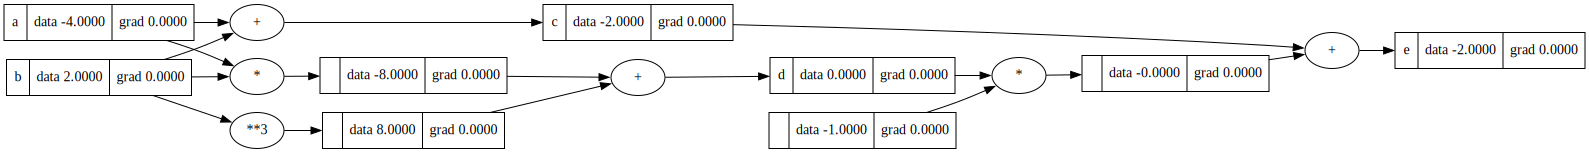

In [65]:
a = Value(-4.0, label='a')
b = Value(2.0, label='b')
c = a + b; c.label = 'c'
d = a * b + b**3; d.label = 'd'
e = c - d; e.label = 'e'
draw_dot(e)

In [66]:
e.grad = 1
e._backward()
